Preprocessing function 

In [1]:
import re
import pandas as pd

def preprocess_ocr_text(text) -> str:
    if not isinstance(text, str):
        return ""
    # Replace known OCR noise characters
    text = text.replace("â€œ", "").replace("â€", "").replace("â€˜", "").replace("â€™", "'")

    # Remove unwanted symbols
    text = re.sub(r"(â|Â|¢|§|«|©|®|€|“|”|‘|’|™|…|_|=||•|—|–|@|%|<|>|\\|\||~|`)", "", text)

    # Fix common formatting issues
    text = re.sub(r"(\d)(tab/s|tablet[s]?|cap[s]?|capsule[s]?)", r"\1 tablet", text, flags=re.IGNORECASE)
    text = re.sub(r"(\d)(times)", r"\1 times", text, flags=re.IGNORECASE)
    text = re.sub(r"(\d)\s*x\s*(a|per)?\s*day", r"\1 times a day", text, flags=re.IGNORECASE)

    # Normalize known expressions
    replacements = {
        "twice a day": "2 times a day",
        "three times daily": "3 times a day",
        "when necessary": "when needed",
        "when required": "when needed",
    }

    for wrong, correct in replacements.items():
        text = re.sub(rf"\b{wrong}\b", correct, text, flags=re.IGNORECASE)

    #remove irrelevant data
    lines = text.splitlines()
    cleaned = []

    for line in lines:
        # Skip if line contains clinic/address info
        if any(x in line for x in ["clinic", "centre", "hospital", "#", "blk", "building", "road", "s "]):
            continue
        # Skip prices and quantities
        if re.search(r"\bqty\b|\bprice\b|\$\d+|\d+\.\d{2}", line):
            continue
        cleaned.append(line)
    

    # Remove extra whitespace
    text = re.sub(r"\s+", " ", text)

    return text.strip()

df = pd.read_csv("50_new_sample.csv")
df["extracted_text"] = df["extracted_text"].apply(preprocess_ocr_text)
df.to_csv("cleaned_50_new_sample.csv", index=False)

#do not change to lowercase as it will affect the keyword matching later for medication!

    


labeling of the text

In [2]:
import pandas as pd
import json
import re

# Define your CSV file and column
csv_file = "cleaned_50_new_sample.csv"
column_name = "extracted_text"

# Define keyword groups for automatic tagging
keywords1 = {
    "DOSAGE": ["tablet", "tablets", "teblet", "tab", "tabs", "tab/s","cap/s","cap", "capsule", "capsules"],
    "FREQUENCY": ["times", "time", "hour", "hours","hourly","morning", "evening", "afternoon", "bedtime", "night"]
}

keywords2 = {
    "FREQUENCY": ["once", "twice"],
    "INSTRUCTION": ["when","needed", "after", "use","before", "after", "with", "without", "meal", "meals", "food", "swallow","chew"],
    "NOTE" : ["fever","pain", "cough", "cold", "flu", "runny", "allergy", "infection", "inflammation", "swelling", "sore throat", "headache", "nausea","gastric", "drowsiness", "vomiting", "diarrhea", "constipation", "rash", "itching", "fatigue", "dizziness"]
}


# split sentence into tokens using regex
def tokenize(text):
    return re.findall(r"\b\w+(?:/\w+)?\b", text.lower())

# Auto-label function (basic BIO tagging)
def auto_label(tokens):
    labels = ["O"] * len(tokens)

    quantity_words = {
        "1", "2", "3", "4", "5", "10", "one", "two", "three", "four", "five", "half", "quarter"
    }

    # Collect known keywords
    known_keywords = set()
    for group in [*keywords1.values(), *keywords2.values()]:
        known_keywords.update(word.lower() for word in group)

    #MEDICATION_NAME tagging to tag the first unknown word
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        if (
            labels[i] == "O"
            and token_lower not in known_keywords
            and token_lower.isalpha()
            and len(token) > 3
        ):
            labels[i] = "B-MEDICATION_NAME"
            break  # only tag the first one

    #DOSAGE tagging
    dosage_candidates = [
        i for i in range(1, len(tokens))
        if tokens[i].lower() in keywords1["DOSAGE"] and tokens[i - 1].lower() in quantity_words
    ]

    if len(dosage_candidates) == 1:
        i = dosage_candidates[0]
        labels[i - 1] = "B-DOSAGE"
        labels[i] = "I-DOSAGE"
    elif len(dosage_candidates) >= 2:
        i = dosage_candidates[1]  # tag only the second
        labels[i - 1] = "B-DOSAGE"
        labels[i] = "I-DOSAGE"

    #FREQUENCY tagging
    for i in range(1, len(tokens)):
        if (
            tokens[i].lower() in keywords1["FREQUENCY"] and 
            tokens[i - 1].lower()
        ):
            labels[i - 1] = "B-FREQUENCY"
            labels[i] = "I-FREQUENCY"

    #keywords2 tagging
    for i, token in enumerate(tokens):
        token_lower = token.lower()
        for label, keyword_list in keywords2.items():
            if token_lower in keyword_list and labels[i] == "O":
                labels[i] = f"B-{label.upper()}"
                if (
                    i + 1 < len(tokens) and 
                    tokens[i + 1].lower() in keyword_list
                ):
                    labels[i + 1] = f"I-{label.upper()}"

    return labels



# Load CSV
df = pd.read_csv(csv_file)

# Clean nulls and whitespace
df = df[df[column_name].notnull()]
df[column_name] = df[column_name].astype(str).str.strip()

# Build token-label pairs
data = []
for text in df[column_name]:
    tokens = tokenize(text)
    labels = auto_label(tokens)
    data.append({"tokens": tokens, "labels": labels})

# Save to JSON
with open("auto_labeled_ner_data50.json", "w") as f:
    json.dump(data, f, indent=2)

print("Auto-labeling complete!")




Auto-labeling complete!


to do augmentation on the new 50 labels to increase to 300 samples

In [1]:
import json
import random
import nltk
from nltk.corpus import wordnet
import os

nltk.download('wordnet')

# ========== Load original data ==========
with open("auto_labeled_ner_data50.json", "r") as f:
    original_data = json.load(f)

# ========== Get synonyms ==========
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for l in syn.lemmas():
            synonym = l.name().replace("_", " ").lower()
            if synonym != word.lower() and synonym.isalpha():
                synonyms.add(synonym)
    return list(synonyms)

# ========== Augment one sample ==========
def augment_sample(sample, num_aug=5):
    tokens, labels = sample['tokens'], sample['labels']
    augmented = []

    for _ in range(num_aug):
        new_tokens = []
        for token, label in zip(tokens, labels):
            if label == "O" and random.random() < 0.3:
                synonyms = get_synonyms(token)
                new_token = random.choice(synonyms) if synonyms else token
            else:
                new_token = token
            new_tokens.append(new_token)

        augmented.append({
            "tokens": new_tokens,
            "labels": labels.copy()
        })

    return augmented

# ========== Apply to all data ==========
augmented_data = []
for sample in original_data:
    augmented_data.append(sample)  # keep original
    augmented_data.extend(augment_sample(sample, num_aug=5))  # add 5 augmented

# ========== Save to file ==========
output_file = "50augmented_data.json"
with open(output_file, "w") as f:
    json.dump(augmented_data, f, indent=2)

print(f"✅ Augmented data saved to {output_file} with {len(augmented_data)} samples.")


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\prisc\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


✅ Augmented data saved to 50augmented_data.json with 300 samples.


combine clean_clean.json has 116 samples and 50augmented_data.json has 300 samples manually - combined_for_bert_training.json

In [5]:
!pip install transformers datasets seqeval scikit-learn
!pip install "accelerate>=0.26.0"
!pip install --upgrade transformers

!pip install torchvision
!pip install torch


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import torch
import torchvision

print(torch.__version__)
print(torchvision.__version__)


2.7.1+cpu
0.22.1+cpu


In [3]:
import json

with open("combined_for_bert_training.json", "r") as f:
    data = json.load(f)

# Fix typo in labels
for example in data:
    example["labels"] = [
        "I-INSTRUCTION" if label == "I-NSTRUCTION" else label
        for label in example["labels"]
    ]

# Save fixed file
with open("labels_for_bert_training.json", "w") as f:
    json.dump(data, f, indent=2)

print("labels_for_bert_training.json")


labels_for_bert_training.json


training BERT model 

Map:   0%|          | 0/307 [00:00<?, ? examples/s]

Map:   0%|          | 0/77 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\prisc\AppData\Local\Temp\ipykernel_7080\4253562998.py:109: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.800300,0.339466,0.904542,0.839685,0.894958,0.866441
2,0.206500,0.310940,0.920323,0.865937,0.886555,0.876125
3,0.127700,0.295032,0.941493,0.915531,0.941176,0.928177
4,0.096300,0.299984,0.946882,0.914286,0.941176,0.927536
5,0.084800,0.330772,0.939184,0.918256,0.943978,0.930939
6,0.072800,0.313680,0.947652,0.924761,0.946779,0.935640


C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*ar


 Evaluation Metrics:
eval_loss: 0.2950
eval_accuracy: 0.9415
eval_precision: 0.9155
eval_recall: 0.9412
eval_f1: 0.9282
eval_runtime: 29.5279
eval_samples_per_second: 2.6080
eval_steps_per_second: 0.3390
epoch: 6.0000


Device set to use cpu



 Inference Output:
2 tablets → DOSAGE
3 times → FREQUENCY
after food → INSTRUCTION
      loss  grad_norm  learning_rate  epoch  step  eval_loss  eval_accuracy  \
0   0.8003   3.227071       0.000049    1.0    39        NaN            NaN   
1      NaN        NaN            NaN    1.0    39   0.339466       0.904542   
2   0.2065   6.375703       0.000048    2.0    78        NaN            NaN   
3      NaN        NaN            NaN    2.0    78   0.310940       0.920323   
4   0.1277   3.112709       0.000047    3.0   117        NaN            NaN   
5      NaN        NaN            NaN    3.0   117   0.295032       0.941493   
6   0.0963   2.875639       0.000046    4.0   156        NaN            NaN   
7      NaN        NaN            NaN    4.0   156   0.299984       0.946882   
8   0.0848   3.628720       0.000045    5.0   195        NaN            NaN   
9      NaN        NaN            NaN    5.0   195   0.330772       0.939184   
10  0.0728   0.263091       0.000044    6.0   2

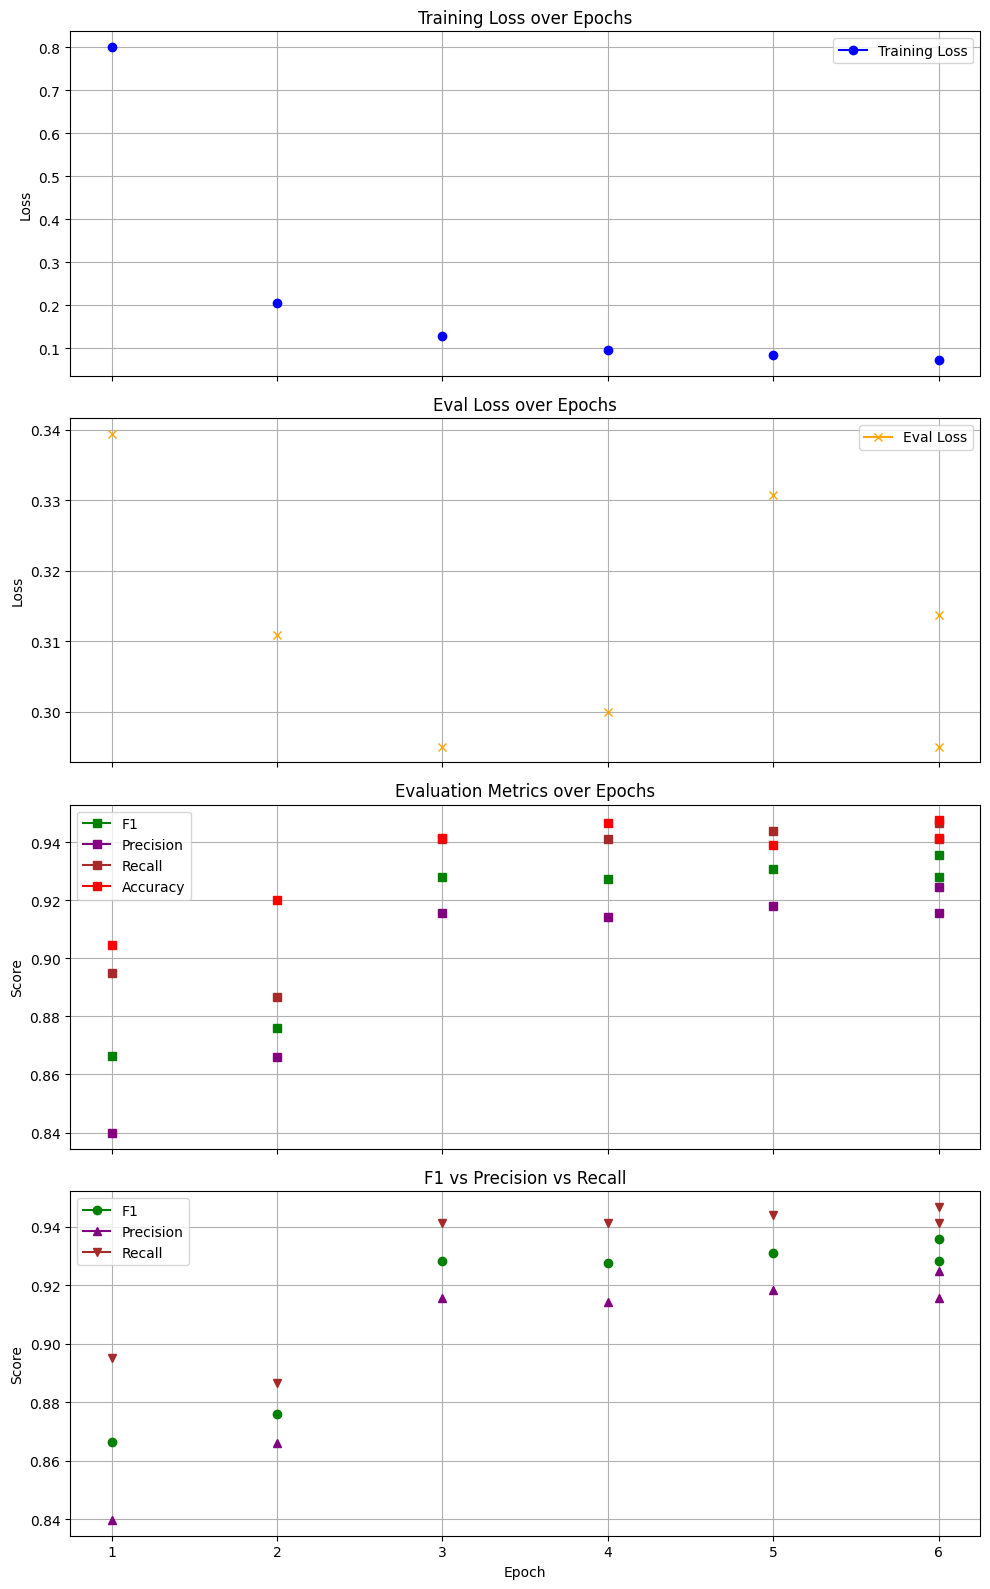

In [8]:
import json
from datasets import Dataset, DatasetDict
from transformers import BertTokenizerFast, BertForTokenClassification
from transformers import TrainingArguments, Trainer
from transformers import pipeline
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from seqeval.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import pandas as pd

#Load Data 
with open("labels_for_bert_training.json", "r") as f:
    data = json.load(f)

#train test split 
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
dataset = DatasetDict({
    "train": Dataset.from_list(train_data),
    "test": Dataset.from_list(test_data)
})

#Create Label Mapping to number labels for training
label_list = [
    "B-DOSAGE", "I-DOSAGE",
    "B-FREQUENCY", "I-FREQUENCY",
    "B-INSTRUCTION", "I-INSTRUCTION",
    "B-MEDICATION_NAME", "I-MEDICATION_NAME",
    "B-NOTE", "I-NOTE",
    "O"
]

label_to_id = {label: i for i, label in enumerate(label_list)}
id_to_label = {i: label for label, i in label_to_id.items()}
num_labels = len(label_list)

# pre-trained tokenizer to tokenize the text with ids
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")
 
# Tokenization and label alignment
def tokenize_and_align_labels(example):
    tokenized_inputs = tokenizer(example["tokens"], is_split_into_words=True, padding='max_length', truncation=True)
    word_ids = tokenized_inputs.word_ids()

    labels = []
    previous_word_idx = None
    for word_idx in word_ids:
        if word_idx is None:
            labels.append(-100)
        else:
            labels.append(label_to_id[example["labels"][word_idx]])
        previous_word_idx = word_idx

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

tokenized_datasets = dataset.map(tokenize_and_align_labels)

# Load model
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=num_labels,
    id2label=id_to_label,
    label2id=label_to_id
)

# Compute metrics for evaluation
def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)

    true_labels = []
    true_predictions = []

    for pred, label in zip(predictions, labels):
        current_preds = []
        current_labels = []
        for p_i, l_i in zip(pred, label):
            if l_i != -100:
                current_preds.append(id_to_label[p_i])
                current_labels.append(id_to_label[l_i])
        true_predictions.append(current_preds)
        true_labels.append(current_labels)

    return {
        "accuracy": accuracy_score(true_labels, true_predictions),
        "precision": precision_score(true_labels, true_predictions),
        "recall": recall_score(true_labels, true_predictions),
        "f1": f1_score(true_labels, true_predictions),
    }

#Training set up
training_args = TrainingArguments(
    output_dir="./ner_model3",
    save_safetensors=False,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False
)


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]  # adjust patience if needed
)

#Train Model 
trainer.train()

#Save Model 
model_path = "./ner_medication_model3"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

#Evaluate on test Set 
eval_results = trainer.evaluate()
print("\n Evaluation Metrics:")
for k, v in eval_results.items():
    print(f"{k}: {v:.4f}")

#Inference Example 
ner_pipe = pipeline("ner", model=model_path, tokenizer=model_path, aggregation_strategy="simple")
text = "Take 2 tablets 3 times a day after food"
results = ner_pipe(text)
print("\n Inference Output:")
for entity in results:
    print(f"{entity['word']} → {entity['entity_group']}")

#evaluation output
logs = trainer.state.log_history
df_logs = pd.DataFrame(logs)
print(df_logs)

if "epoch" in df_logs.columns:
    fig, axs = plt.subplots(4, 1, figsize=(10, 16), sharex=True)

    # 1. Training Loss
    if "loss" in df_logs.columns:
        axs[0].plot(df_logs["epoch"], df_logs["loss"], label="Training Loss", marker='o', color='blue')
        axs[0].set_title("Training Loss over Epochs")
        axs[0].set_ylabel("Loss")
        axs[0].legend()
        axs[0].grid(True)

    # 2. Eval Loss
    if "eval_loss" in df_logs.columns:
        axs[1].plot(df_logs["epoch"], df_logs["eval_loss"], label="Eval Loss", marker='x', color='orange')
        axs[1].set_title("Eval Loss over Epochs")
        axs[1].set_ylabel("Loss")
        axs[1].legend()
        axs[1].grid(True)

    # 3. Eval F1, Precision, Recall, Accuracy
    metrics = ["eval_f1", "eval_precision", "eval_recall", "eval_accuracy"]
    colors = ["green", "purple", "brown", "red"]
    for i, metric in enumerate(metrics):
        if metric in df_logs.columns:
            axs[2].plot(df_logs["epoch"], df_logs[metric], label=metric.replace("eval_", "").capitalize(),
                        marker='s', color=colors[i])

    axs[2].set_title("Evaluation Metrics over Epochs")
    axs[2].set_ylabel("Score")
    axs[2].legend()
    axs[2].grid(True)

    # 4. Combined (F1, Precision, Recall)
    if all(m in df_logs.columns for m in ["eval_f1", "eval_precision", "eval_recall"]):
        axs[3].plot(df_logs["epoch"], df_logs["eval_f1"], label="F1", marker='o', color='green')
        axs[3].plot(df_logs["epoch"], df_logs["eval_precision"], label="Precision", marker='^', color='purple')
        axs[3].plot(df_logs["epoch"], df_logs["eval_recall"], label="Recall", marker='v', color='brown')
        axs[3].set_title("F1 vs Precision vs Recall")
        axs[3].set_xlabel("Epoch")
        axs[3].set_ylabel("Score")
        axs[3].legend()
        axs[3].grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("No 'epoch' column found in logs to plot.")

In [14]:
from transformers import pipeline
from collections import defaultdict

# Load BERT NER pipeline
ner_pipe = pipeline(
    "ner",
    model="./ner_medication_model3",
    tokenizer="./ner_medication_model3",
    aggregation_strategy="simple"  # ensures "2 tablets" is treated as one
)

text = "Take 2 tablets 3 times a day after food loratadine may cause drowsiness"

# Run inference
results = ner_pipe(text)

# Group output by entity type 
grouped_output = defaultdict(list)
for entity in results:
    label = entity["entity_group"]  # e.g. B-DOSAGE
    word = entity["word"]

    # Normalize label (strip B- or I- prefixes)
    base_label = label.split("-")[-1] if "-" in label else label
    grouped_output[base_label].append(word)

# results to display in console here to fit into the format that required to show in mobile
def clean_prediction(grouped_output):
    final = {}

    # Medication name: only take the first word
    meds = grouped_output.get("MEDICATION_NAME", [])
    if meds:
        final["medication_name"] = meds[0]

    # Dosage: take only the first numeric token, or fallback to first token
    dosages = grouped_output.get("DOSAGE", [])
    filtered = [w for w in dosages if w.isnumeric()]
    if filtered:
        final["dosage"] = filtered[0]
    elif dosages:
        final["dosage"] = dosages[0]

    # Frequency, Instruction, Note: keep full phrases
    for field in ["FREQUENCY", "INSTRUCTION", "NOTE"]:
        value = " ".join(grouped_output.get(field, []))
        if value:
            final[field.lower()] = value

    return final

# Apply postprocessing
final_output = clean_prediction(grouped_output)

# Print results
for k, v in final_output.items():
    print(f"{k.capitalize()}: {v}")

#Convert to JSON string
json_output = json.dumps(final_output, indent=4)
print("JSON Output:")
print(json_output)
with open("ner_output.json", "w") as f:
    f.write(json_output)


Device set to use cpu


Medication_name: lo
Dosage: 2 tablets
Frequency: 3 times
Instruction: after food
Note: d ##rows ##iness
JSON Output:
{
    "medication_name": "lo",
    "dosage": "2 tablets",
    "frequency": "3 times",
    "instruction": "after food",
    "note": "d ##rows ##iness"
}


In [2]:
! pip install transformers

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [46]:
import difflib
import json
from collections import defaultdict
from transformers import pipeline
import pandas as pd

# === 1. Load drug name vocabulary ===
drug_names_df = pd.read_csv(
    "drugbank vocabulary.csv",
    quoting=3,
    on_bad_lines='skip',
    engine='python'
)

drug_name_set = set()
if 'name' in drug_names_df.columns:
    drug_name_set.update(drug_names_df['name'].dropna().str.lower())

print(f"Loaded {len(drug_name_set)} drug names.")

# === 2. Correction helper ===
def correct_medication_name(name, dictionary):
    name = name.lower()
    match = difflib.get_close_matches(name, dictionary, n=1, cutoff=0.7) 
    return match[0] if match else name


def word_to_number(word):
    word_map = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "half": 0.5,
        "quarter": 0.25
    }
    return word_map.get(word.lower(), None)


# === 3. Inference + postprocessing function ===
def infer_and_format(text, model_path, drug_name_set, save_json=True, json_path="ner_output1.json"):
    ner_pipe = pipeline("ner", model=model_path, tokenizer=model_path, aggregation_strategy="none")
    results = ner_pipe(text)

    #1: Merge subword tokens manually
    merged_tokens = []
    for ent in results:
        word = ent["word"]
        if word.startswith("##") and merged_tokens:
            merged_tokens[-1]["word"] += word[2:]
        else:
            merged_tokens.append(ent)

    #2: Group by entity type
    grouped_output = defaultdict(list)
    for ent in merged_tokens:
        label = ent["entity"]
        base_label = label.split("-")[-1] if "-" in label else label
        grouped_output[base_label].append(ent["word"])

    #3: Correct medication names with dictionary words
    if "MEDICATION_NAME" in grouped_output:
        full_name = " ".join(grouped_output["MEDICATION_NAME"])
        corrected = correct_medication_name(full_name, drug_name_set)
        grouped_output["MEDICATION_NAME"] = [corrected]


    # Step 4a: Original format output
    final = {}

    meds = grouped_output.get("MEDICATION_NAME", [])
    if meds:
        final["medication_name"] = meds[0]

    dosages = grouped_output.get("DOSAGE", [])
    numeric = [w for w in dosages if w.isnumeric()]
    if numeric:
        final["dosage"] = numeric[0]
    elif dosages:
        final["dosage"] = dosages[0]

    for field in ["FREQUENCY", "INSTRUCTION", "NOTE"]:
        value = " ".join(grouped_output.get(field, []))
        if value:
            final[field.lower()] = value

    # Step 4b: New format with frequency rules
    custom = {}

    # Medication name
    if meds:
        custom["medication_name"] = meds[0]

    # Dosage number
    custom["dosage"] = 0  # default
    for w in dosages:
        if w.isnumeric():
            custom["dosage"] = int(w)
            break
        val = word_to_number(w)
        if val is not None:
            custom["dosage"] = val
            break

    # Frequency handling
    freq_tokens = grouped_output.get("FREQUENCY", [])
    freq_num = []
    freq_words = []

    for w in freq_tokens:
        if w.lower() in {"times", "time"}:
            continue  # skip filler words
        if w.isnumeric():
            freq_num.append(int(w))
        else:
            val = word_to_number(w)
            if val is not None:
                freq_num.append(val)
            else:
                freq_words.append(w)


    if freq_num:
        custom["frequency"] = freq_num[0]
    elif freq_words:
        custom["frequency"] = 1
    else:
        custom["frequency"] = 0


    # Instruction includes: frequency words + original instruction
    instruction_tokens = freq_words + grouped_output.get("INSTRUCTION", [])
    if instruction_tokens:
        custom["instruction"] = " ".join(instruction_tokens)

    # Note
    note = " ".join(grouped_output.get("NOTE", []))
    if note:
        custom["note"] = note

       # Step 5: Print both outputs
    print("\n Final Prediction (Original Format):")
    for k, v in final.items():
        print(f"{k.capitalize()}: {v}")

    print("\n Final Prediction (Custom Format):")
    for k, v in custom.items():
        print(f"{k.capitalize()}: {v}")

    # Step 6: Save both to JSON
    if save_json:
        with open(json_path, "w") as f:
            json.dump(final, f, indent=4)
        print(f"📁 Saved JSON to {json_path}")

        alt_path = json_path.replace(".json", "_custom.json")
        with open(alt_path, "w") as f:
            json.dump(custom, f, indent=4)
        print(f"📁 Saved JSON to {alt_path}")

# === 4. Run the function ===
model_path = "./ner_medication_model3"
text = "loratadine Take one tablets 3 times a day after food may cause drowsiness"
output = infer_and_format(text, model_path, drug_name_set)


Device set to use cpu


Loaded 9041 drug names.


C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Final Prediction (Original Format):
Medication_name: loratadine
Dosage: one
Frequency: 3 times
Instruction: after food
Note: drowsiness

 Final Prediction (Custom Format):
Medication_name: loratadine
Dosage: 1
Frequency: 3
Instruction: after food
Note: drowsiness
📁 Saved JSON to ner_output1.json
📁 Saved JSON to ner_output1_custom.json


In [35]:
results = ner_pipe(text)
for r in results:
    print(r)


{'entity_group': 'DOSAGE', 'score': np.float32(0.98158026), 'word': 'one tablets', 'start': 5, 'end': 16}
{'entity_group': 'FREQUENCY', 'score': np.float32(0.9938452), 'word': '3 times', 'start': 17, 'end': 24}
{'entity_group': 'INSTRUCTION', 'score': np.float32(0.90974236), 'word': 'after food', 'start': 31, 'end': 41}
{'entity_group': 'NOTE', 'score': np.float32(0.955019), 'word': 'd', 'start': 60, 'end': 61}
{'entity_group': 'NOTE', 'score': np.float32(0.9719285), 'word': '##rows', 'start': 61, 'end': 65}
{'entity_group': 'NOTE', 'score': np.float32(0.96279216), 'word': '##iness', 'start': 65, 'end': 70}


In [45]:
print("augmentin" in drug_name_set)  # should be True



False


In [49]:
import difflib
import json
from collections import defaultdict
from transformers import pipeline
import pandas as pd

# === 1. Load drug name vocabulary ===
drug_names_df = pd.read_csv(
    "drugbank vocabulary.csv",
    quoting=3,
    on_bad_lines='skip',
    engine='python'
)

drug_name_set = set()
if 'name' in drug_names_df.columns:
    drug_name_set.update(drug_names_df['name'].dropna().str.lower())

print(f"Loaded {len(drug_name_set)} drug names.")

# === 2. Correction helper ===
def correct_medication_name(name, dictionary):
    name = name.lower()
    match = difflib.get_close_matches(name, dictionary, n=1, cutoff=0.7) 
    return match[0] if match else name


def word_to_number(word):
    word_map = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "half": 0.5,
        "quarter": 0.25
    }
    return word_map.get(word.lower(), None)


# === 3. Inference + postprocessing function ===
def infer_and_format(text, model_path, drug_name_set, save_json=True, json_path="ner_output1.json"):
    ner_pipe = pipeline("ner", model=model_path, tokenizer=model_path, aggregation_strategy="none")
    results = ner_pipe(text)

    # Step 1: Merge subword tokens
    merged_tokens = []
    for ent in results:
        word = ent["word"]
        if word.startswith("##") and merged_tokens:
            merged_tokens[-1]["word"] += word[2:]
        else:
            merged_tokens.append(ent)

    # Step 2: Group by label
    grouped_output = defaultdict(list)
    for ent in merged_tokens:
        label = ent["entity"]
        base_label = label.split("-")[-1] if "-" in label else label
        grouped_output[base_label].append(ent["word"])

    # Step 3: Correct medication names
    if "MEDICATION_NAME" in grouped_output:
        full_name = " ".join(grouped_output["MEDICATION_NAME"])
        corrected = correct_medication_name(full_name, drug_name_set)
        grouped_output["MEDICATION_NAME"] = [corrected]

    # === Original Format ===
    final = {}

    meds = grouped_output.get("MEDICATION_NAME", [])
    if meds:
        final["medication_name"] = meds[0]

    dosages = grouped_output.get("DOSAGE", [])
    numeric = [w for w in dosages if w.isnumeric()]
    if numeric:
        final["dosage"] = numeric[0]
    elif dosages:
        final["dosage"] = dosages[0]

    for field in ["FREQUENCY", "INSTRUCTION", "NOTE"]:
        value = " ".join(grouped_output.get(field, []))
        if value:
            final[field.lower()] = value

    # === Custom Format (not printed) ===
    custom = {}
    if meds:
        custom["medication_name"] = meds[0]

    # Dosage
    custom["dosage"] = 0
    for w in dosages:
        if w.isnumeric():
            custom["dosage"] = int(w)
            break
        val = word_to_number(w)
        if val is not None:
            custom["dosage"] = val
            break

    # Frequency
    freq_tokens = grouped_output.get("FREQUENCY", [])
    freq_num = []
    freq_words = []
    for w in freq_tokens:
        if w.lower() in {"times", "time"}:
            continue
        if w.isnumeric():
            freq_num.append(int(w))
        else:
            val = word_to_number(w)
            if val is not None:
                freq_num.append(val)
            else:
                freq_words.append(w)

    if freq_num:
        custom["frequency"] = freq_num[0]
    elif freq_words:
        custom["frequency"] = 1
    else:
        custom["frequency"] = 0

    instruction_tokens = freq_words + grouped_output.get("INSTRUCTION", [])
    if instruction_tokens:
        custom["instruction"] = " ".join(instruction_tokens)

    note = " ".join(grouped_output.get("NOTE", []))
    if note:
        custom["note"] = note

    # === Print ONLY original format ===
    print("\n🔹 Final Prediction (Original Format):")
    for k, v in final.items():
        print(f"{k.capitalize()}: {v}")

    # === Save both JSONs ===
    if save_json:
        with open(json_path, "w") as f:
            json.dump(final, f, indent=4)
        print(f"📁 Saved JSON to {json_path}")


# === 4. Run the function ===
model_path = "./ner_medication_model3"
text = "loratadine Take one tablets 3 times a day after food may cause drowsiness"
output = infer_and_format(text, model_path, drug_name_set)


Device set to use cpu


Loaded 9041 drug names.

🔹 Final Prediction (Original Format):
Medication_name: loratadine
Dosage: one
Frequency: 3 times
Instruction: after food
Note: drowsiness
📁 Saved JSON to ner_output1.json


C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [1]:
import difflib
import json
from collections import defaultdict
from transformers import pipeline
import pandas as pd

# === 1. Load drug name vocabulary ===
drug_names_df = pd.read_csv(
    "drugbank vocabulary.csv",
    quoting=3,
    on_bad_lines='skip',
    engine='python'
)

drug_name_set = set()
if 'name' in drug_names_df.columns:
    drug_name_set.update(drug_names_df['name'].dropna().str.lower())

print(f"Loaded {len(drug_name_set)} drug names.")

# === 2. Correction helper ===
def correct_medication_name(name, dictionary):
    name = name.lower()
    match = difflib.get_close_matches(name, dictionary, n=1, cutoff=0.7) 
    return match[0] if match else name


def word_to_number(word):
    word_map = {
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "half": 0.5,
        "quarter": 0.25
    }
    return word_map.get(word.lower(), None)


# === 3. Inference + postprocessing function ===
def infer_and_format(text, model_path, drug_name_set, save_json=True, json_path="ner_output1.json"):
    ner_pipe = pipeline("ner", model=model_path, tokenizer=model_path, aggregation_strategy="none")
    results = ner_pipe(text)

    #1: Merge subword tokens manually
    merged_tokens = []
    for ent in results:
        word = ent["word"]
        if word.startswith("##") and merged_tokens:
            merged_tokens[-1]["word"] += word[2:]
        else:
            merged_tokens.append(ent)

    #2: Group by entity type
    grouped_output = defaultdict(list)
    for ent in merged_tokens:
        label = ent["entity"]
        base_label = label.split("-")[-1] if "-" in label else label
        grouped_output[base_label].append(ent["word"])

    #3: Correct medication names with dictionary words
    if "MEDICATION_NAME" in grouped_output:
        full_name = " ".join(grouped_output["MEDICATION_NAME"])
        corrected = correct_medication_name(full_name, drug_name_set)
        grouped_output["MEDICATION_NAME"] = [corrected]


    # Step 4a: Original format output
    final = {}

    meds = grouped_output.get("MEDICATION_NAME", [])
    if meds:
        final["medication_name"] = meds[0]

    dosages = grouped_output.get("DOSAGE", [])
    numeric = [w for w in dosages if w.isnumeric()]
    if numeric:
        final["dosage"] = numeric[0]
    elif dosages:
        final["dosage"] = dosages[0]

    for field in ["FREQUENCY", "INSTRUCTION", "NOTE"]:
        value = " ".join(grouped_output.get(field, []))
        if value:
            final[field.lower()] = value

    # Step 4b: New format with frequency rules
    custom = {}

    # Medication name
    if meds:
        custom["medication_name"] = meds[0]

    # Dosage number
    custom["dosage"] = 0  # default
    for w in dosages:
        if w.isnumeric():
            custom["dosage"] = int(w)
            break
        val = word_to_number(w)
        if val is not None:
            custom["dosage"] = val
            break

    # Frequency handling
    freq_tokens = grouped_output.get("FREQUENCY", [])
    freq_num = []
    freq_words = []

    for w in freq_tokens:
        if w.lower() in {"times", "time"}:
            continue  # skip filler words
        if w.isnumeric():
            freq_num.append(int(w))
        else:
            val = word_to_number(w)
            if val is not None:
                freq_num.append(val)
            else:
                freq_words.append(w)


    if freq_num:
        custom["frequency"] = freq_num[0]
    elif freq_words:
        custom["frequency"] = 1
    else:
        custom["frequency"] = 0


    # Instruction includes: frequency words + original instruction
    instruction_tokens = freq_words + grouped_output.get("INSTRUCTION", [])
    if instruction_tokens:
        custom["instruction"] = " ".join(instruction_tokens)

    # Note
    note = " ".join(grouped_output.get("NOTE", []))
    if note:
        custom["note"] = note

    # Step 5: Print  outputs
    print("\n Final Prediction (Custom Format):")
    for k, v in custom.items():
        print(f"{k.capitalize()}: {v}")

    # Step 6: Save to JSON
    if save_json:
        alt_path = json_path.replace(".json", "_custom.json")
        with open(alt_path, "w") as f:
            json.dump(custom, f, indent=4)
        print(f"Saved JSON to {alt_path}")

# === 4. Run the function ===
model_path = "./ner_medication_model3"
text = "loratadine Take one tablets 3 times a day after food may cause drowsiness"
output = infer_and_format(text, model_path, drug_name_set)


Loaded 9041 drug names.


Device set to use cpu
C:\Users\prisc\AppData\Roaming\Python\Python313\site-packages\torch\nn\modules\module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)



 Final Prediction (Custom Format):
Medication_name: loratadine
Dosage: 1
Frequency: 3
Instruction: after food
Note: drowsiness
Saved JSON to ner_output1_custom.json


In [1]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("./ner_medication_model3")
text = "Take one tablets of loratadine 3 times a day after food. May cause drowsiness."

# Print tokens
tokens = tokenizer(text, return_offsets_mapping=True, return_tensors="pt", truncation=True, padding=True)
decoded = tokenizer.convert_ids_to_tokens(tokens['input_ids'][0])
print("🔍 Tokens:", decoded)

🔍 Tokens: ['[CLS]', 'Take', 'one', 'tablets', 'of', 'lo', '##rata', '##dine', '3', 'times', 'a', 'day', 'after', 'food', '.', 'May', 'cause', 'd', '##rows', '##iness', '.', '[SEP]']


In [5]:
!python --version





Python 3.13.2


In [1]:
from transformers import pipeline
pipe = pipeline("ner", model="model", tokenizer="model")


OSError: model is not a local folder and is not a valid model identifier listed on 'https://huggingface.co/models'
If this is a private repository, make sure to pass a token having permission to this repo either by logging in with `hf auth login` or by passing `token=<your_token>`